# ENTRENAMIENTO MODELO DE CLASIFICACIÓN MULTICLASE.


#### Autor: Víctor Barcina Muñoz

### Entrenamiento del modelo. Arquitectura VGG16


VGG 16 constituye una herramienta para Clasificar Imágenes de Keras. . El tamaño de entrada predeterminado debe ser de (224x224) píxele
.Los argumentos de `de `V` son: G16`

- **include_top**: Indica si se incluyen las tres capas totalmente conectadas al final de la red.
- **weights**: Especifica el tipo de pesos iniciales del modelo:
  - `None`: Inicialización aleatoria.
  - `"imagenet"`: Pesos preentrenados en ImageNet.
  - Ruta a un archivo de pesos.
- **input_tensor**: Permite definir un tensor de entrada personalizado para el modelo. (Opcional)
- **input_shape**: Tupla opcional que define las dimensiones de entrada si `include_top=False`. 
  - La forma debe ser `(224, 224, 3)` o `(3, 224, 224)`, dependiendo del formato de canales, con al menos 3 canales y tamaño mínimo de `32x32`.
- **pooling**: Determina el método de extracción de características cuando `include_top=False`:
  - `None`: Devuelve un tensor 4D del último bloque convolucional.
  - `avg`: Aplica un average pooling global para devolver un tensor 2D.
  - `max`: Aplica max pooling global.
- **classes**: Número de clases para clasificar, solo se define si `include_top=True` y no se especifican pesos.
- **classifier_activation**: Define la activación para la capa final cuando `include_top=True`. Puede ser `None` o `"softmax"` al usar pesos preentrenados, permitiendo obtener los logits de la capa superior.
- **name**: Nombre del modelo.
l modelo.



In [25]:
#se cargan las librerías necesarias
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils import class_weight
import numpy as np
import tensorflow as tf

'''
Para entrenar el modelo se va a emplear Transfer Learning, es decir, se va a aprovechar el conocimiento adquirido de un entrenamiento ya realizado
para mejorar el rendimiento del nuestro. La arquitectura empleada es VGG16. 

En primer lugar es necesario definir el modelo preentrenado para su uso (VGG16)
VGG se trata de un modelo entrenado durante semanas, cuya mejora respecto al resto es que propone núcleos de convolución más pequeños, 
alcanzando precisiones muy elevadas en ImageNet, la cual es una gran BD de código abierto que contiene millones de imágenes etiquetadas por humanos.

VGG16 es un modelo de red neuronal profunda conocido por su efectividad en tareas de clasificación de imágenes. Sus características principales son:
- **Capas Convolucionales**: Utiliza filtros de tamaño 3x3, permitiendo capturar características locales en las imágenes de manera efectiva.
- **Pooling**: En la arquitectura original de VGG16, se aplica **Max-Pooling** con un tamaño de 2x2 después de ciertas capas convolucionales para reducir 
la dimensionalidad del espacio de características. Sin embargo, en esta implementación, se utiliza **Global Average Pooling** después de las capas
convolucionales, lo cual reduce el riesgo de sobreajuste al generar un único valor promedio por cada mapa de características, en lugar de tomar el
máximo.
- **Capas Fully Connected (Dense)**: A la salida de las capas convolucionales, el modelo original de VGG16 contiene:
  - Dos capas densas con 4096 neuronas cada una, utilizando la función de activación ReLU (Rectified Linear Unit), que permite modelar relaciones no 
  lineales.
  - Una capa de salida con 1000 neuronas (una por cada clase en ImageNet) con función de activación Softmax, que convierte los valores en 
  probabilidades que suman 1.

## Preprocesamiento de las Imágenes
Las imágenes de entrada deben ser de tamaño (224x224) píxeles y deben ser preprocesadas antes de ser alimentadas al modelo. Esto incluye la
normalización de los valores RGB, donde se resta la media de los píxeles del conjunto de datos de entrenamiento de ImageNet. Esto asegura que los
datos de entrada sean consistentes con los datos en los que fue entrenado el modelo VGG16.

## Parámetros Importantes
El script incluye varios parámetros clave que deben ser configurados manualmente:
- **`weights`**: Se establece como 'imagenet' para utilizar los pesos preentrenados del modelo VGG16.
- **`include_top`**: Se establece en `False` para excluir la parte final del modelo, permitiendo la personalización para un nuevo conjunto de clases.
- **`input_shape`**: Se define como `(224, 224, 3)` para indicar el tamaño de las imágenes de entrada y que el modelo espera imágenes RGB.

## Entrenamiento del Modelo
Durante el entrenamiento, se aprovechan los pesos preentrenados de VGG16, ajustando las capas finales para adaptarlas a un nuevo conjunto de clases. 
En este caso, se añaden capas densas que clasifican las imágenes en tres clases:
- **Melanoma (mel)**
- **Carcinoma Basocelular (bcc)**
- **Carcinoma Espinocelular (bkl)**

### Detalles del Entrenamiento
- **Aumento de Datos**: Se utiliza `ImageDataGenerator` para realizar aumentos en las imágenes de entrenamiento, como rotaciones,
desplazamientos y volteos, lo que ayuda a mejorar la generalización del modelo.
- **Cálculo de Pesos de Clase**: Se calculan pesos de clase para compensar el desequilibrio en el conjunto de datos, asegurando que las clases menos
representadas tengan mayor peso durante el entrenamiento.
- **Callbacks**: Se implementan varias funciones de callback para optimizar el proceso de entrenamiento:
  - **EarlyStopping**: Detiene el entrenamiento si no hay mejora en la pérdida de validación después de un número definido de épocas.
  - **ReduceLROnPlateau**: Reduce la tasa de aprendizaje si la mejora en la pérdida de validación se estanca.
  - **ModelCheckpoint**: Guarda el modelo cuando se observa una mejora en la pérdida de validación.

## Evaluación del Modelo
Después del entrenamiento, se evalúa la precisión del modelo en las clases específicas, proporcionando una visión detallada de su rendimiento y 
permitiendo ajustes si es necesario.

Este enfoque no solo permite aprovechar la potencia de un modelo previamente entrenado, sino que también facilita la adaptación a nuevas tareas de
clasificación de imágenes de manera eficiente y efectiva
'''

# Definición del modelo base VGG16
#Pesos de ImageNet
#Exlusión de la capa final del modelo para reemplazarlas por las nuestras
#Tamaño de imágenes y canal RGB
modelo_preentrenado = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Descongelamos las últimas capas de VGG16 para fine-tuning controlado
for capa in modelo_preentrenado.layers[:-10]:  
    capa.trainable = False

# Capas adicionales para clasificación
salida_base = modelo_preentrenado.output #Obtenemos la salida de la última capa del modelo preentrenado
salida_pooled = GlobalAveragePooling2D()(salida_base) #Reduce sobreajuste reduciendo la dimensionalidad del volumen de características
salida_densa_1 = Dense(256, activation='relu')(salida_pooled) #capa de neuronas con función relu para propagar valores positivos
salida_dropout_1 = Dropout(0.3)(salida_densa_1) #Regularización para prevenir sobreajuste
salida_densa_2 = Dense(128, activation='relu')(salida_dropout_1)#capa de neuronas con función relu para propagar valores positivos
salida_dropout_2 = Dropout(0.3)(salida_densa_2)#Regularización para prevenir sobreajuste
salida_final = Dense(3, activation='softmax')(salida_dropout_2) # Capa final Dense con 3 neuronas.Predicción de tres clases: mel, bcc, bkl
# Definimos el modelo final, que toma la entrada de VGG16 y produce la salida final definida
modelo = Model(inputs=modelo_preentrenado.input, outputs=salida_final)

# Compilación del modelo con un learning rate bajo
modelo.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Aumento de datos con ImageDataGenerator
generador_entrenamiento = ImageDataGenerator(
    rotation_range=20, #rotacion
    width_shift_range=0.1, # desplazamiento horizontal
    height_shift_range=0.1, #desplazamiento vertical
    zoom_range=0.2, #zoom
    horizontal_flip=True, #volteo de imagen
    fill_mode='nearest' #Relleno de píxeles
)
generador_validacion = ImageDataGenerator()  #no hay aumentos para que las imágenes sean iguales a las del entrenamiento

# Configuración de generadores con balance de clases para cargar imágenes de las carpetas de entrenamiento
generador_imagenes_entrenamiento = generador_entrenamiento.flow_from_directory(
    './train',
    target_size=(224, 224), #dimensiones de la imagen
    batch_size=16, #Número de imágenes procesadas simultáneamente
    class_mode='categorical',
    classes=['mel', 'bcc', 'bkl']
)
generador_imagenes_validacion = generador_validacion.flow_from_directory(
    './val',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    classes=['mel', 'bcc', 'bkl']
)

# Calcular pesos de clase para compensar el desequilibrio
contar_clases = generador_imagenes_entrenamiento.classes
#Calculamos pesos de cada clase de manera que esten balanceadas. Las clases menos representadas tendrán más valor, y viceversa
pesos_clase_balanceados = class_weight.compute_class_weight('balanced', classes=np.unique(contar_clases), y=contar_clases)
#Creamos un diccionario donde cada clave representan las clases, y los valores sus pesos asignados. 
diccionario_pesos_clase = {i: pesos_clase_balanceados[i] for i in range(3)}

# Callbacks para optimización del modelo
#Detiene el entrenamiento si el rendimiento (Val_loss) no mejora tras 10 épocas.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
#Reduce tasa de aprendizaje si la mejora en Val_loss se estanca
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)
#Guarda el modelo cuando se observa una mejora
model_checkpoint = ModelCheckpoint('Modelo_VGG16_VBM.keras', save_best_only=True, monitor='val_loss', mode='min')

#Función personalizada para mostrar precisión de cada clase
class CallbackMetricasPersonalizadas(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        
        '''
        Función que proporciona información sobre el funcinamiento del modelo en cuanto a precisión/clase. 
        Esto se ejecuta al final de cada época de entrenamiento, proporcionando el resultado de precisión/clase. 
        Para ello se realizan predicciones sobre el conjunto de validación. Se emplea armax para obtener la clase con mayor probabilidad para cada imagen
        
        Parámetros
        ----------------------
        epoc: Entero que representa la época que acaba de finalizar

        logs: Diccionario que contiene las métricas de rendimiento del modelo para cada época pérdida, precisión, etc)
                
        Return
        ----------------------
        La función devuelve una lista con las precisiones en cada clase en %.
        '''
        predicciones_validacion = np.argmax(self.model.predict(generador_imagenes_validacion), axis=-1)
        etiquetas_reales = generador_imagenes_validacion.classes
        precision_clase = {}
        
        for i, nombre_clase in enumerate(['mel', 'bcc', 'bkl']):
            verdaderos_positivos = np.sum((predicciones_validacion == i) & (etiquetas_reales == i))
            total_imagenes_clase = np.sum(etiquetas_reales == i)
            precision = verdaderos_positivos / total_imagenes_clase if total_imagenes_clase > 0 else 0
            precision_clase[nombre_clase] = precision * 100
            print(f'Precisión para {nombre_clase} en época {epoch + 1}: {precision_clase[nombre_clase]:.2f}%')
        print("")

# Entrenamiento del modelo
history = modelo.fit(
    generador_imagenes_entrenamiento, #Imágenes de entrenamiento con aumentos, etiquetas y pesos
    epochs=50, # número de épocas
    validation_data=generador_imagenes_validacion, #para evaluar el rendimiento del modelo en cada época sin actualizar pesos
    class_weight=diccionario_pesos_clase, # Añadir pesos de clase
    callbacks=[early_stopping, reduce_lr, model_checkpoint, CallbackMetricasPersonalizadas()]  #ejecución de callbacks
)

# Mostrar la precisión final por clase
print("Precisión final por clase:")
# Realiza predicciones sobre el conjunto de validación utilizando el modelo entrenado
# np.argmax devuelve el índice de la clase con la mayor probabilidad para cada imagen.
prediccion_final = np.argmax(modelo.predict(generador_imagenes_validacion), axis=-1)
# Obtenemos las etiquetas reales del conjunto de validación.
etiquetas_reales_finales = generador_imagenes_validacion.classes
for i, class_name in enumerate(['mel', 'bcc', 'bkl']):
    # Calcula el número de verdaderos positivos: el número de predicciones correctas para la clase actual.
    verdaderos_positivos = np.sum((prediccion_final == i) & (etiquetas_reales_finales == i))
    # Calcula el total de imágenes que pertenecen a la clase actual.
    total_imagenes_clase = np.sum(etiquetas_reales_finales == i)
    # Calcula la precisión: el porcentaje de verdaderos positivos sobre el total de imágenes de la clase.
    # Se asegura de que no se divida por cero.
    precision = verdaderos_positivos / total_imagenes_clase if total_imagenes_clase > 0 else 0
    print(f"Precisión para {class_name}: {precision * 100:.2f}%")


Found 1907 images belonging to 3 classes.
Found 409 images belonging to 3 classes.
Epoch 1/50


C:\Users\victo\anaconda3\anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


26/26 ━━━━━━━━━━━━━━━━━━━━ 157s 6s/step
Precisión para mel en época 1: 71.86%
Precisión para bcc en época 1: 18.18%
Precisión para bkl en época 1: 7.27%

120/120 ━━━━━━━━━━━━━━━━━━━━ 1034s 9s/step - accuracy: 0.3476 - loss: 1.4989 - val_accuracy: 0.5012 - val_loss: 0.9348 - learning_rate: 1.0000e-05
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 153s 6s/stepp 
Precisión para mel en época 2: 53.89%
Precisión para bcc en época 2: 35.06%
Precisión para bkl en época 2: 9.09%

120/120 ━━━━━━━━━━━━━━━━━━━━ 1834s 15s/step - accuracy: 0.4927 - loss: 0.9683 - val_accuracy: 0.5623 - val_loss: 0.8384 - learning_rate: 1.0000e-05
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 132s 5s/step
Precisión para mel en época 3: 58.68%
Precisión para bcc en época 3: 18.18%
Precisión para bkl en época 3: 26.06%

120/120 ━━━━━━━━━━━━━━━━━━━━ 1801s 15s/step - accuracy: 0.5328 - loss: 0.8797 - val_accuracy: 0.6137 - val_loss: 0.7682 - learning_rate: 1.0000e-05
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step
Precisión para mel e

### PRUEBAS DEL MODELO VGG16


Resultados para la clase 'mel':
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step
  Imagen: ISIC_0024313.jpg - Predicción: mel (Confianza: 0.99), Correcta: True
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step
  Imagen: ISIC_0024516.jpg - Predicción: mel (Confianza: 0.92), Correcta: True
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
  Imagen: ISIC_0024546.jpg - Predicción: mel (Confianza: 0.86), Correcta: True
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
  Imagen: ISIC_0024552.jpg - Predicción: mel (Confianza: 0.78), Correcta: True
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step
  Imagen: ISIC_0024640.jpg - Predicción: mel (Confianza: 1.00), Correcta: True
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
  Imagen: ISIC_0024647.jpg - Predicción: bkl (Confianza: 0.44), Correcta: False
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
  Imagen: ISIC_0024675.jpg - Predicción: mel (Confianza: 0.62), Correcta: True
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
  Imagen: ISIC_0024700.jpg - Predicción: mel (Confianza: 0.99), Correcta: True
1/1 ━━━━━━━━━━━━━━━━━━

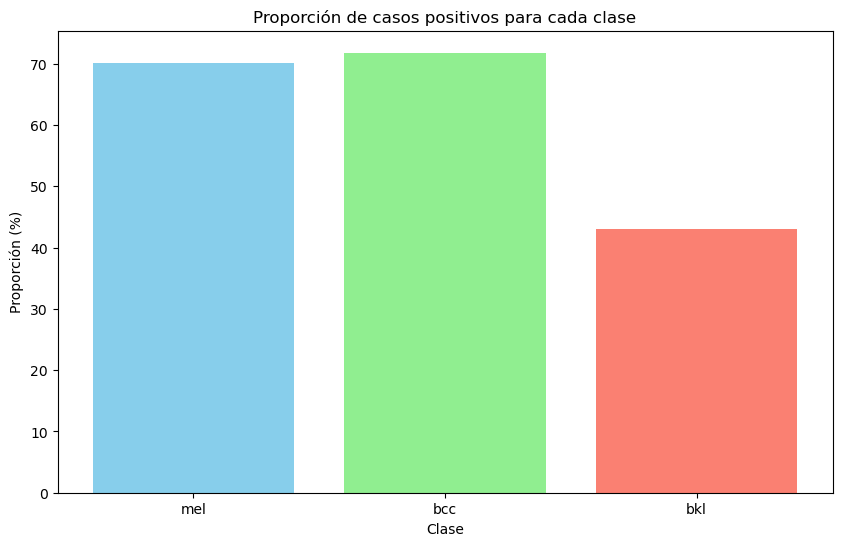

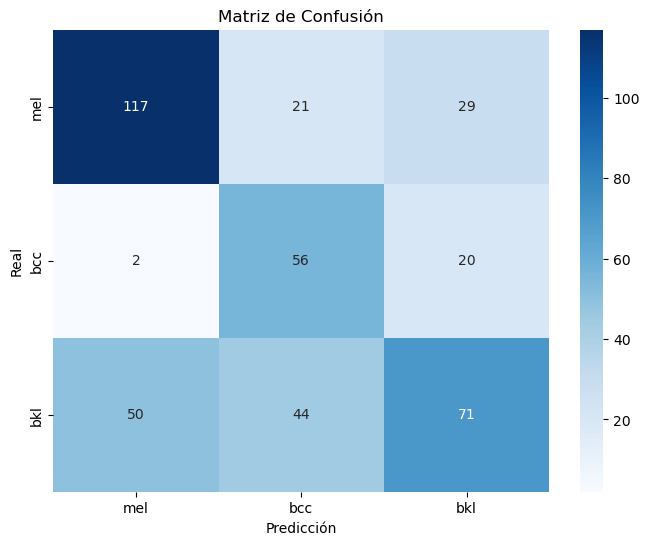


Para la clase 'mel':
  - Verdaderos Positivos (TP): 117
  - Verdaderos Negativos (TN): 191
  - Falsos Positivos (FP): 52
  - Falsos Negativos (FN): 50
  - Exactitud (Accuracy): 75.12%
  - Sensibilidad (Recall): 70.06%
  - Especificidad: 78.60%
  - Precisión: 69.23%

Para la clase 'bcc':
  - Verdaderos Positivos (TP): 56
  - Verdaderos Negativos (TN): 267
  - Falsos Positivos (FP): 65
  - Falsos Negativos (FN): 22
  - Exactitud (Accuracy): 78.78%
  - Sensibilidad (Recall): 71.79%
  - Especificidad: 80.42%
  - Precisión: 46.28%

Para la clase 'bkl':
  - Verdaderos Positivos (TP): 71
  - Verdaderos Negativos (TN): 196
  - Falsos Positivos (FP): 49
  - Falsos Negativos (FN): 94
  - Exactitud (Accuracy): 65.12%
  - Sensibilidad (Recall): 43.03%
  - Especificidad: 80.00%
  - Precisión: 59.17%


In [33]:
#librerias necesarias
import os  
import matplotlib.pyplot as plt  
from tensorflow.keras.models import load_model 
from tensorflow.keras.preprocessing import image  
from tensorflow.keras.applications.vgg16 import preprocess_input  
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np  

# Cargar el modelo previamente guardado
modelo = load_model('Modelo_VGG16_VBM.keras')

# Definir las etiquetas de clase
etiquetas_clase = {0: 'mel', 1: 'bcc', 2: 'bkl'}

tamaño_imagen = (224, 224)  # Tamaño de imagen requerido por el modelo VGG16

# Definir los directorios de imágenes de prueba organizadas por clase
directorios_prueba = {
    'mel': 'test/mel',
    'bcc': 'test/bcc',
    'bkl': 'test/bkl'
}

# Función para evaluar múltiples imágenes de cada clase
def evaluar_imagenes_multiples(modelo, directorios_prueba):
    resultados = {}  # Diccionario para almacenar resultados de precisión por clase
    todas_las_predicciones = []  # Lista para almacenar resultados de cada imagen

    # Iterar sobre cada clase y su carpeta correspondiente
    for etiqueta, carpeta in directorios_prueba.items():
        archivos_imagen = [os.path.join(carpeta, f) for f in os.listdir(carpeta) if os.path.isfile(os.path.join(carpeta, f))]
        
        aciertos_correctos = 0  # Contador para las predicciones correctas
        total_predicciones = len(archivos_imagen)  # Total de imágenes a evaluar
        
        print(f"\nResultados para la clase '{etiqueta}':")

        # Evaluar cada imagen en la carpeta correspondiente
        for ruta_imagen in archivos_imagen:
            # Cargar y preprocesar la imagen
            img = image.load_img(ruta_imagen, target_size=tamaño_imagen)
            array_imagen = image.img_to_array(img)  # Convertir la imagen a un arreglo de numpy
            array_imagen = np.expand_dims(array_imagen, axis=0)  # Agregar una dimensión para el lote
            array_imagen = preprocess_input(array_imagen)  # Preprocesar la imagen según el modelo VGG16
            
            # Realizar la predicción
            prediccion = modelo.predict(array_imagen)
            indice_clase_predicha = np.argmax(prediccion, axis=1)[0]  # Obtener el índice de la clase predicha
            etiqueta_clase_predicha = etiquetas_clase.get(indice_clase_predicha, "Desconocido")  # Obtener la etiqueta correspondiente
            probabilidad_predicha = prediccion[0][indice_clase_predicha]  # Obtener la probabilidad de la predicción

            # Comparar la predicción con la clase esperada
            correcto = (etiqueta_clase_predicha == etiqueta)  # Verificar si la predicción es correcta
            if correcto:
                aciertos_correctos += 1  # Incrementar el contador si la predicción es correcta

            # Agregar la predicción a los resultados generales
            todas_las_predicciones.append({
                'ruta': ruta_imagen,
                'clase_real': etiqueta,
                'clase_predicha': etiqueta_clase_predicha,
                'probabilidad': probabilidad_predicha,
                'correcta': correcto
            })

            # Imprimir el resultado de la imagen actual
            print(f"  Imagen: {os.path.basename(ruta_imagen)} - Predicción: {etiqueta_clase_predicha} "
                  f"(Confianza: {probabilidad_predicha:.2f}), Correcta: {correcto}")

        # Calcular precisión para la clase actual
        precision = (aciertos_correctos / total_predicciones) * 100 if total_predicciones > 0 else 0
        resultados[etiqueta] = {
            'precision': precision,
            'correctas': aciertos_correctos,
            'total': total_predicciones
        }
    
    return resultados, todas_las_predicciones

# Función para calcular y mostrar la matriz de confusión y métricas de rendimiento
def mostrar_matriz_confusion(todas_las_predicciones):
    # Extraer las clases reales y predichas
    clases_reales = [pred['clase_real'] for pred in todas_las_predicciones]
    clases_predichas = [pred['clase_predicha'] for pred in todas_las_predicciones]

    # Generar la matriz de confusión
    cm = confusion_matrix(clases_reales, clases_predichas, labels=list(etiquetas_clase.values()))
    
    # Mostrar la matriz de confusión con un gráfico de calor
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=etiquetas_clase.values(), yticklabels=etiquetas_clase.values())
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title('Matriz de Confusión')
    plt.show()

    total_muestras = cm.sum()  # Total de muestras

    # Imprimir métricas para cada clase
    for i, label in enumerate(etiquetas_clase.values()):
        tp = cm[i, i]  # Verdaderos Positivos
        fn = cm[i, :].sum() - tp  # Falsos Negativos
        fp = cm[:, i].sum() - tp  # Falsos Positivos
        tn = total_muestras - (tp + fn + fp)  # Verdaderos Negativos

        # Calcular métricas
        exactitud = (tp + tn) / total_muestras * 100
        sensibilidad = (tp / (tp + fn)) * 100 if (tp + fn) > 0 else 0
        especificidad = (tn / (tn + fp)) * 100 if (tn + fp) > 0 else 0
        precision = (tp / (tp + fp)) * 100 if (tp + fp) > 0 else 0

        print(f"\nPara la clase '{label}':")
        print(f"  - Verdaderos Positivos (TP): {tp}")
        print(f"  - Verdaderos Negativos (TN): {tn}")
        print(f"  - Falsos Positivos (FP): {fp}")
        print(f"  - Falsos Negativos (FN): {fn}")
        print(f"  - Exactitud (Accuracy): {exactitud:.2f}%")
        print(f"  - Sensibilidad (Recall): {sensibilidad:.2f}%")
        print(f"  - Especificidad: {especificidad:.2f}%")
        print(f"  - Precisión: {precision:.2f}%")

# Evaluar el modelo usando todas las imágenes de prueba en cada carpeta
resultados, todas_las_predicciones = evaluar_imagenes_multiples(modelo, directorios_prueba)

# Mostrar resultados de precisión por clase
print("\nResumen de Precisión por Clase:")
for etiqueta, resultado in resultados.items():
    print(f"Clase '{etiqueta}': Precisión = {resultado['precision']:.2f}% "
          f"({resultado['correctas']} correctas de {resultado['total']} imágenes)")

# Crear gráfico de barras para mostrar precisión por clase
etiquetas = list(resultados.keys())  # Obtener etiquetas de clase
precisiones = [resultados[etiqueta]['precision'] for etiqueta in etiquetas]  # Obtener precisiones

plt.figure(figsize=(10, 6))  # Definir el tamaño de la figura
plt.bar(etiquetas, precisiones, color=['skyblue', 'lightgreen', 'salmon'])  # Crear gráfico de barras
plt.xlabel("Clase")  # Etiqueta del eje x
plt.ylabel("Proporción (%)")  # Etiqueta del eje y
plt.title("Proporción de casos positivos para cada clase")  # Título del gráfico
plt.show()  # Mostrar el gráfico

# Llamar a la función para mostrar la matriz de confusión y métricas
mostrar_matriz_confusion(todas_las_predicciones)
